In [1]:
description = '''
Lets open up some pickle files and plot the H and CIV lines
'''

In [2]:
import sys, os, re
from typing import Union
import pickle
import numpy as np
import numpy.polynomial.legendre as L

from linetools.spectra.xspectrum1d import XSpectrum1D
from GUIs.abstools import Absorber as A
from GUIs.abstools import Metal_Plot as M  
# M.Plotting( )
bu_path = '/Users/robertseaton/School/github_repos/CGM-learning/code'
if bu_path not in sys.path:
    sys.path.append(bu_path)
import bobutils.utils as bu



In [3]:
#
# NOTE: THIS CODE WON'T WORK INSIDE VSCODE - RUN IT IN A "REAL" JUPYTER LAB INSTANCE!! ----------------
#
%matplotlib inline 
import matplotlib
from matplotlib import gridspec
import matplotlib.pyplot as plt
import seaborn as sns

# my_cmap = sns.color_palette("husl", 20)

In [4]:
def find_pickle_files(basedir):
    return (os.path.join(root, file)
        for root, dirs, files in os.walk(basedir)
            for file in files if file.lower().endswith('.p'))

In [5]:
def get_sightline_from_path(path: str) -> Union[str, None]:
    """Extract the sightline from the path."""
    sightline_match = re.search(r'[\w\d\_\+]+/(\d+)_', path)
    if sightline_match:
        sightline = sightline_match.group(1)
    else:
        sightline = None
    return sightline

def get_redshift_from_path(path: str) -> Union[float, None]:
    """Extract the redshift from the path."""
    redshift_match = re.search(r'z_([\d.]+)', path)
    if redshift_match:
        redshift = float(redshift_match.group(1))
    else:
        redshift = None
    return redshift

def get_ion_index_from_path(path: str) -> Union[int, None]:
    """Extract the ion index from the path."""
    ion_index_match = re.search(r'Ions(\d+)', path)
    if ion_index_match:
        ion_index = int(ion_index_match.group(1))
    else:
        ion_index = None
    return ion_index

def get_tuple_from_path(path: str) -> Union[tuple, None]:
    """Extract the sightline, redshift, and ion index from the path."""
    sightline = get_sightline_from_path(path)
    redshift = get_redshift_from_path(path)
    if sightline and redshift:
        return (sightline, redshift)
    else:
        return None

In [6]:
def open_pfile(basedir, z):
    pfile = basedir + '/' + "Spectrum_Analysis_z_" + str(z) + ".p"
    # print(f"pfile: {pfile}")
    if not os.path.exists(pfile): 
        print(f"\nERROR: pickle file {pfile} does not exist!\n")
        sys.exit(-1)

    with open(pfile,'rb') as pickle_file:
        # display the contents of the pickle file
        print(pickle_file)
        

In [7]:
def plot_simple(xdata, ydata, err, label, figsize=(6, 2), dpi=100, fontsize=12):
    plt.close()
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax_spec = fig.add_axes((0,0,1,1))

    ax_spec.step(xdata, ydata, '-', color="k", linewidth=0.5, label="flux")
    ax_spec.set_xlabel('wavelength (Angstroms)')
    ax_spec.set_ylabel('Flux', color='k', rotation=90)  # Primary y-axis label, rotated
    ax_spec.tick_params(axis='y', labelcolor='k')
    ax_spec.step(xdata, err, '-', color="r", linewidth=0.5, label="error")
    ax_spec.legend(loc='upper right', fontsize=fontsize-2)

    ax_spec.text(0.05, 0.9, 
            f"{label}",
            color="w", 
            fontsize = fontsize, 
            ha='left', va='top',
            transform=ax_spec.transAxes)
 
    ax_spec.set_facecolor('darkgrey')
    
    display(fig) # plots the figure as a static png    
    # plt.close('all')
    # fig, ax = plt.subplots()
    # ax.plot([1, 2, 3, 4], [1, 4, 2, 3])
#     plt.show()

In [8]:
def plot_spectra(sl, xspec, label, figsize=(8,2), dpi=200, fontsize=12):
    """plot_spectra plots the associated XSpectrum1D with a single sightline. 
    Args:   sl (Sightline): _description_
            spec_block (spec,var,wave): _description_
    """
    wave = xspec.wavelength.value
    spec = xspec.flux.value
    err = xspec.sig.value
        
    plt.close()
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax_spec = fig.add_axes((0,0,1,1))

    ax_spec.plot(wave, spec, '-', color="k", linewidth=0.5, label="flux")
    ax_spec.set_xlabel('wavelength (Angstroms)')
    ax_spec.set_ylabel('Flux', color='k', rotation=90)  # Primary y-axis label, rotated
    ax_spec.tick_params(axis='y', labelcolor='k')
    ax_spec.plot(wave, err, '-', color="r", linewidth=0.5, label="error")
    ax_spec.legend(loc='upper right', fontsize=fontsize-2)

    ax_spec.text(0.05, 0.9, 
            f"{label}",
            color="w", 
            fontsize = fontsize, 
            ha='left', va='top',
            transform=ax_spec.transAxes)
 
    ax_spec.set_facecolor('darkgrey')
    
    display(fig) # plots the figure as a static png

In [9]:
def plot_ion_panel(ion_data, label="SL:X", figsize=(8, 2), dpi=100, fontsize=12):
    #---------------Define variables for readability--------------#
    vel = ion_data['vel']
    wave = ion_data['wave']
    error = ion_data['error']
    flux = ion_data['flux']
    weight = ion_data['weight']
    name = ion_data['name']
    #L = ion_data.L
    wc =np.array(ion_data['wc']&(error != 0)) #error != 0 is a bad pixel mask 
    cont = ion_data['cont']
    window_lim = ion_data['window_lim']
    order = ion_data['order']
    EWlims = ion_data['EWlims']
    EW_text = ion_data['text']
    
    lam_0=ion_data['lam_0']
    fvals=ion_data['f']
    z= ion_data['z']
    

    #-------------------------- set up figure -------------------------#
    # plt.close()
    fig = plt.figure(figsize=figsize, dpi=dpi)
    fig.set_figheight(2)
    fig.set_figwidth(20)    

    spec = gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[2, 2], wspace=0.2, hspace=0.2)

    ax_L = fig.add_subplot(spec[0])
    ax_R = fig.add_subplot(spec[1])
    
    sns.set()

    #-------------------------- begin drawing -------------------------#

    #gray_idx is to avoid line plotted through spectra from discontinuity in flux/vel/err from wc mask.
    #uses np.diff to find where wc (true/false array) changes and plots the line segments instead of the full line with missing values
    if wc[0] == True:
        gray_idx = np.where(np.diff(wc,prepend=np.nan))[0][1:]
    else:
        gray_idx = np.where(np.diff(wc,prepend=np.nan))[0]
        
    ax_L.clear()
    ax_L.step(vel,flux,color='k',where='mid');ax_L.step(vel,error,color='r',where='mid')
    ax_L.step(vel,cont,color='b',where='mid')
    for zz in range(int(len(gray_idx)/2)):
        #gray_idx = gray_idx-1
        ax_L.step(vel[gray_idx[zz*2]:gray_idx[2*zz+1]],flux[gray_idx[2*zz]:gray_idx[2*zz+1]],vel[gray_idx[2*zz]:gray_idx[2*zz+1]],error[gray_idx[2*zz]:gray_idx[2*zz+1]],where='mid',color='lightgray',linewidth=1.3,alpha=1)
    
    #clear axes to redraw modifications
    ax_R.clear()

    #plot right (flux; error)
    ax_R.step(vel,flux/cont,color='k',where='mid');ax_R.step(vel,error/cont,color='r',where='mid')
    ax_R.axhline(y=1,xmin=window_lim[0],xmax=window_lim[1],ls='--',c='b')

    #clear y ticks and label plots
    ax_L.set_yticks([]); #parent.axesR[i][ii].set_yticks([])
    ax_L.set_ylabel(name); ax_R.set_ylabel(name)

    #set axes bounds
    ax_L.set_xlim(window_lim); ax_R.set_xlim(window_lim)
    ax_R.set_ylim([0,2.2])
    
    ax_L.set_xlabel('Velocity (km/s)')
    ax_R.set_xlabel('Velocity (km/s)')
    ax_L.set_title('Continuum Fitter')
    ax_R.set_title('Normalized Spectra')

    #plot vel = 0 line
    ax_L.axvline(0,ymin=0,ymax=ax_L.get_ylim()[1],ls='--',c='k')
    ax_R.axvline(0,ymin=0,ymax=ax_R.get_ylim()[1],ls='--',c='k')

    #Plot EW velocity limit
    if EWlims[0] is not None: ax_R.axvline(EWlims[0],ymin=0,ymax=2.5,ls='--',c='b')
    if EWlims[1] is not None: ax_R.axvline(EWlims[1],ymin=0,ymax=2.5,ls='--',c='r')

    ax_L.text(0.50,0.85,label,
              horizontalalignment='center',
              verticalalignment='center',
              transform=ax_L.transAxes,color='blue')
    ax_R.text(0.05,0.85,f'EW: {EW_text}',
              horizontalalignment='left',
              transform=ax_R.transAxes,color='black')
    
    plt.subplots_adjust(wspace=0.2)
    plt.draw()
    


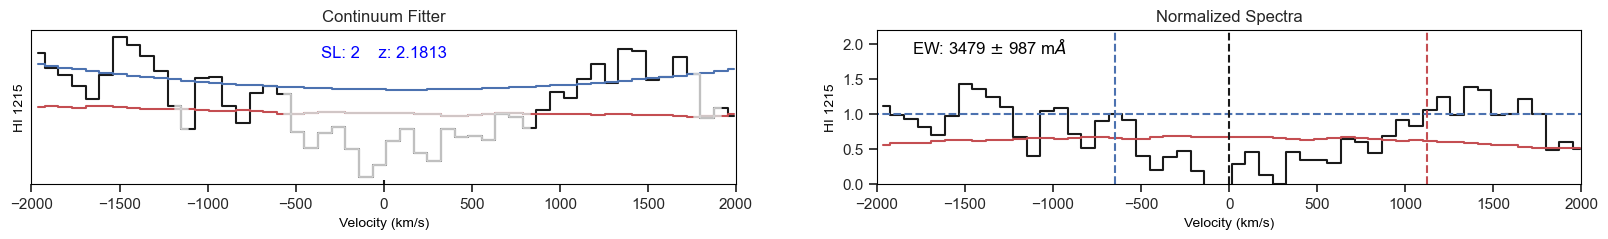

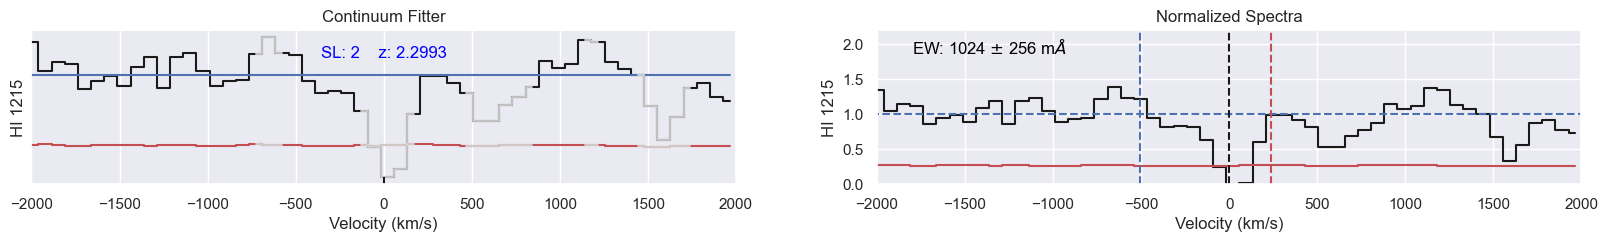

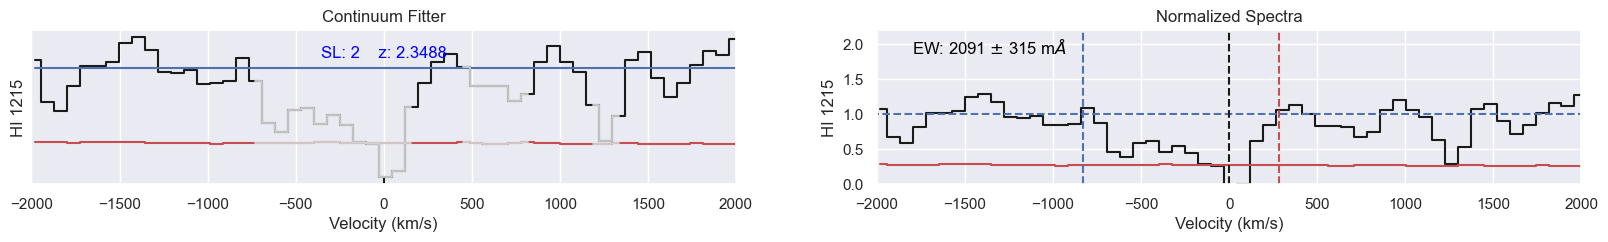

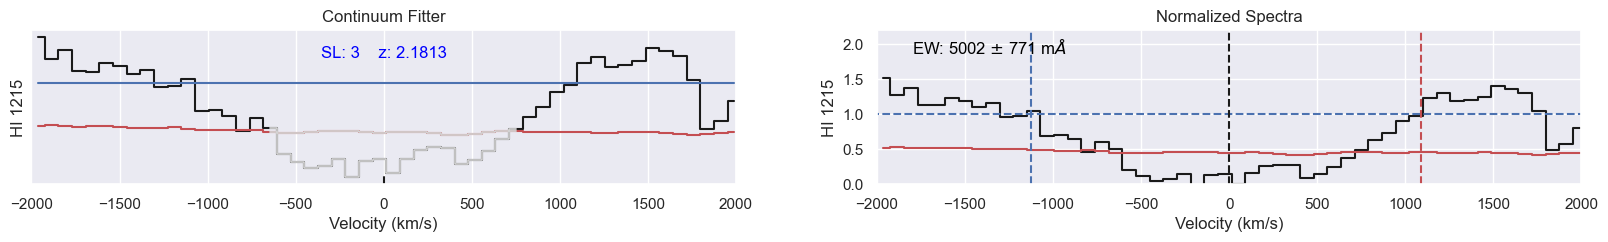

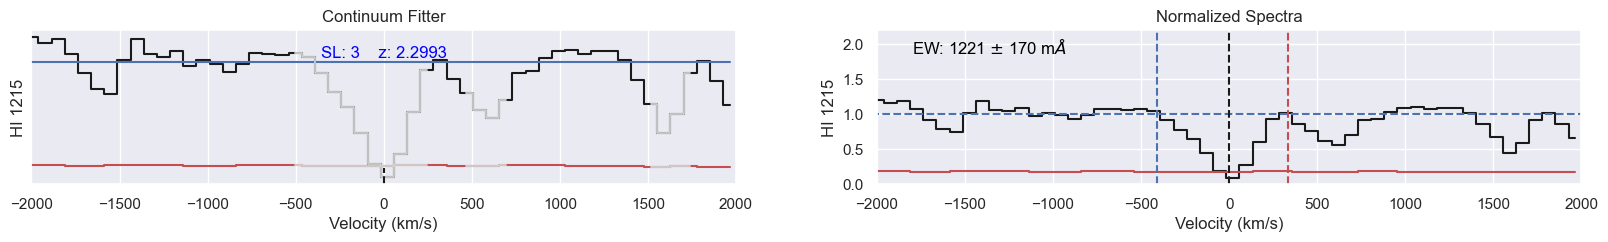

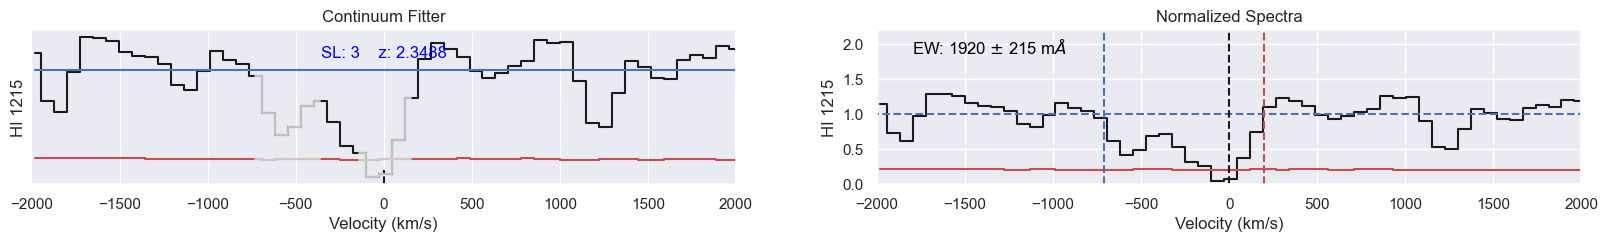

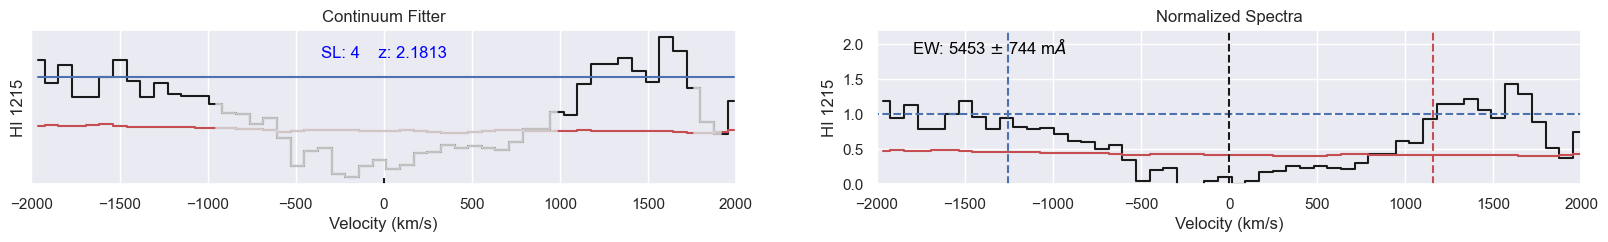

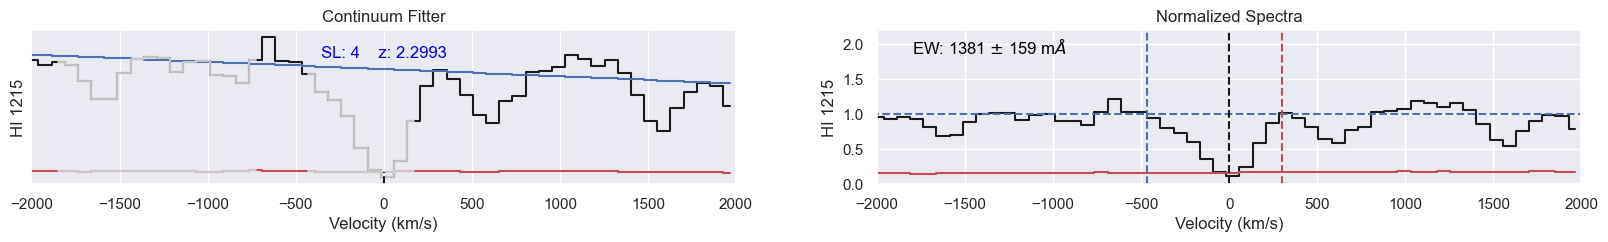

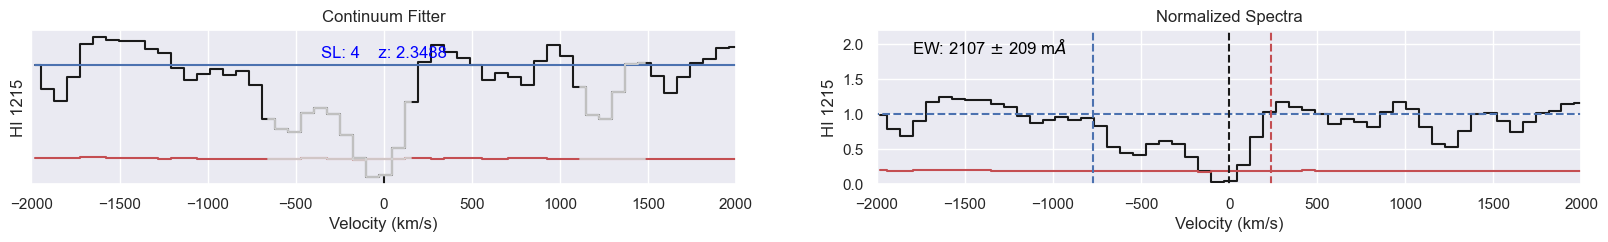

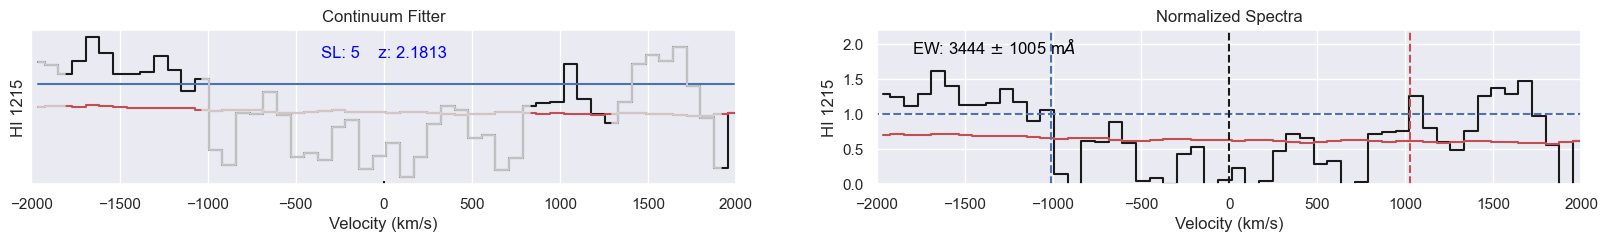

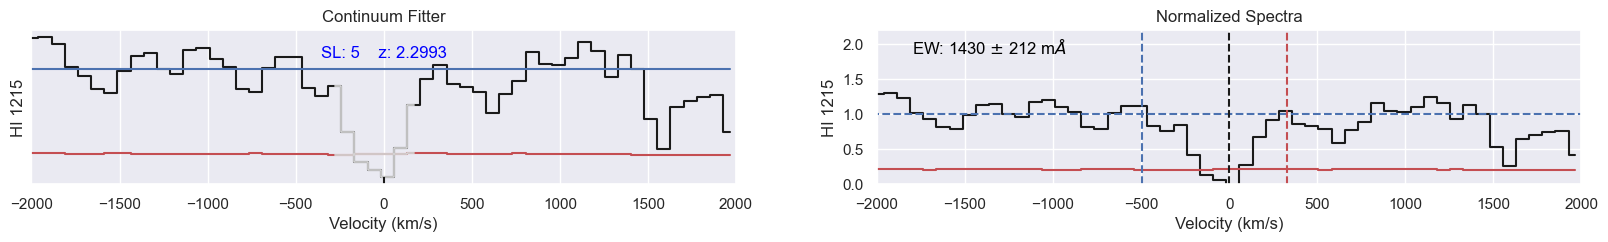

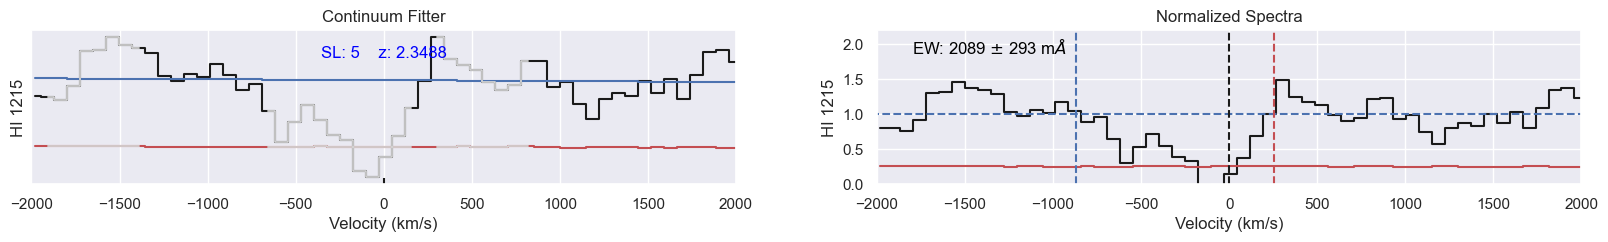

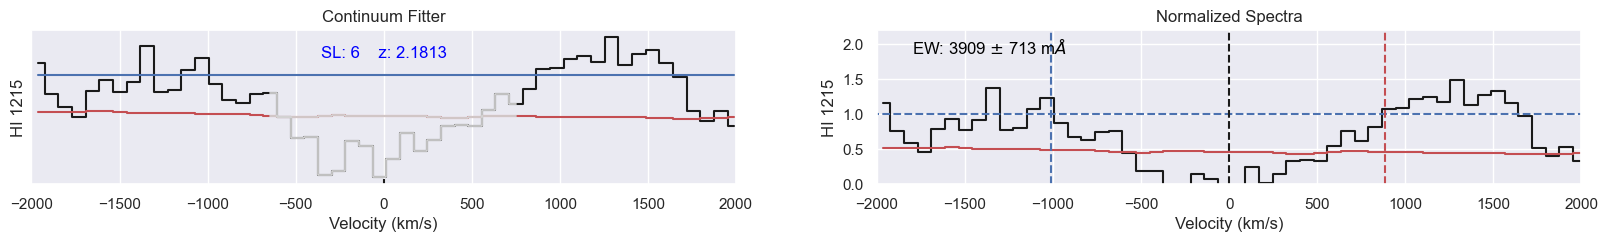

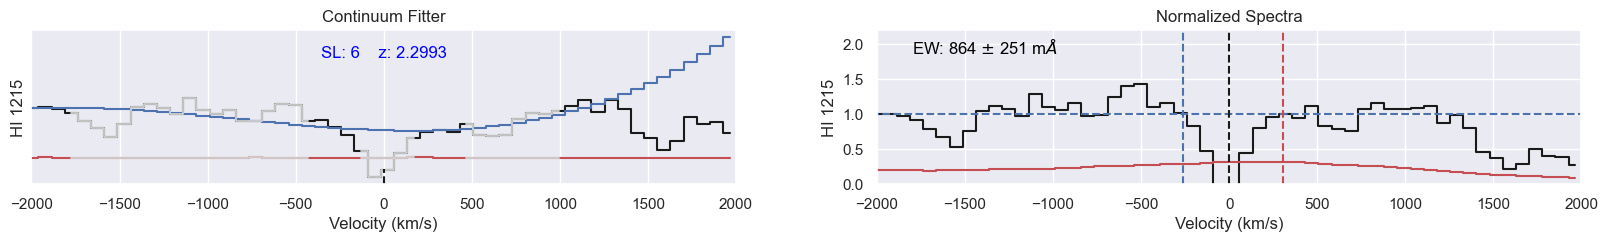

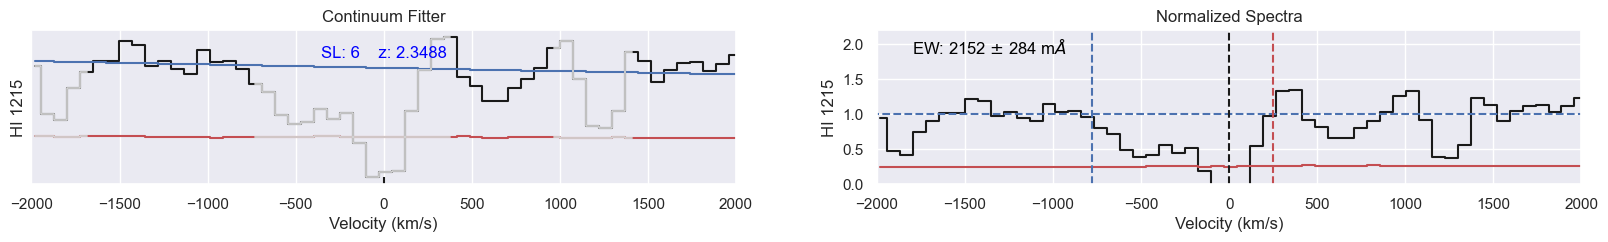

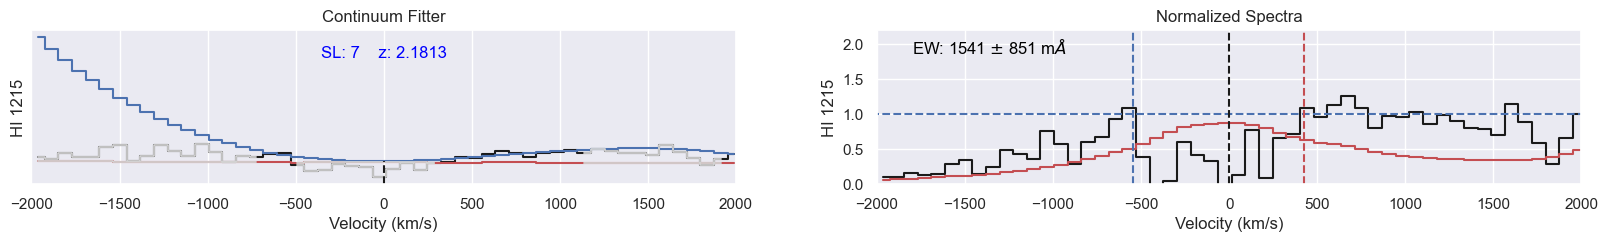

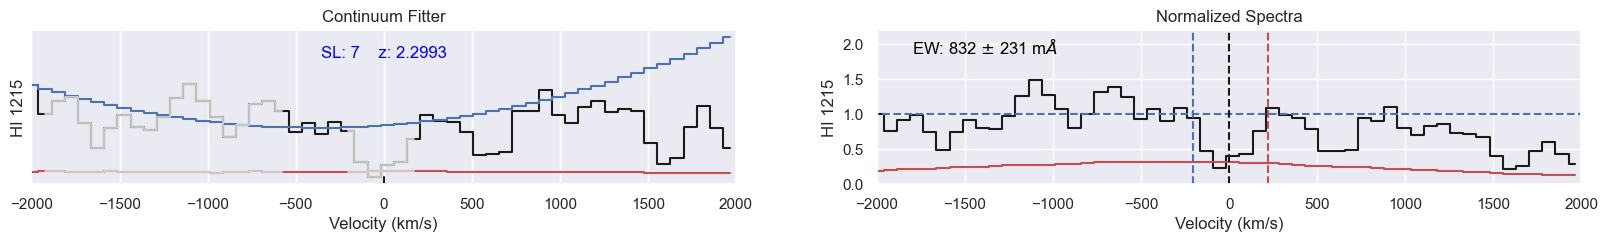

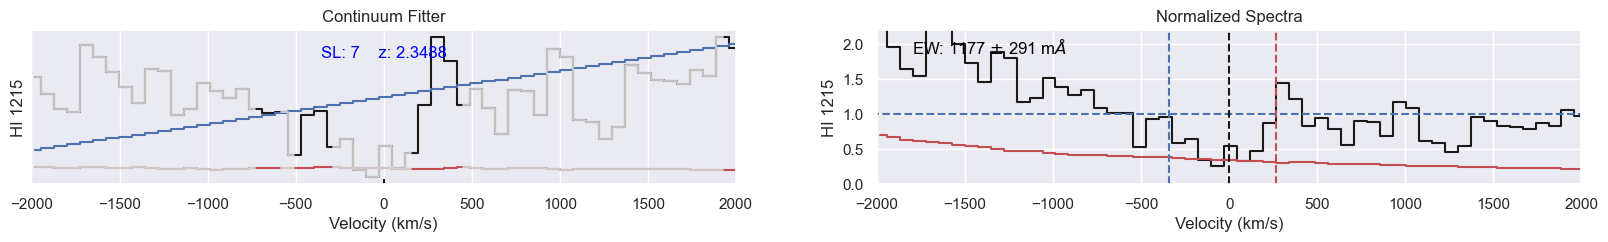

In [10]:
# let's find the pickle files
basedir = "/Users/robertseaton/School/github_repos/CGM-learning/code/analysis/J1429+1202_240131/combined_spectra"
files = list(sorted(find_pickle_files(basedir)))

for i,pfile in enumerate(files):
    # if i > 1: break
    (sightline, redshift) = get_tuple_from_path(pfile)
    label = f"SL: {sightline}    z: {redshift}"
    # print(label)
    with open(pfile,'rb') as pickle_file:
        ions = pickle.load(pickle_file)
        pickle_file.close()

        for ion in ions:
            # if ion is not None and (ion == 'CIV 1548' or ion == 'CIV 1550' or ion == 'HI 1215'):
            if ion is not None and (ion == 'HI 1215'):
                # print(f"matched ion: {ion}")
                ion_data = ions[ion]
                # for key in ion_data:
                #     print(f"{key=} : {ion_data[key]=}")
                plot_ion_panel(ion_data, label=label)
        

In [11]:
def init_figure(panel_title, panel_count, figsize=(8, 2), dpi=100):
    """ create the matplotlib axes we'll draw our panels in """
    #-------------------------- set up figure -------------------------#
    # plt.close()
    fig = plt.figure(figsize=figsize, dpi=dpi)
    fig.suptitle(panel_title, size=22.0, weight=0.5)

    fig.set_figheight(8)
    fig.set_figwidth(20)    
    cols = 2
    rows = int((panel_count + 1) / cols)
    spec = gridspec.GridSpec(ncols=cols, nrows=rows, width_ratios=[2, 2], wspace=0.2, hspace=0.2)
    ax = []
    for i in range(panel_count):
        ax.append(fig.add_subplot(spec[i]))
    
    sns.set()
    return fig, ax

In [12]:
def plot_ion_panel_condensed(panel_ax, ion_data, label="SL:X", fontsize=12, is_top=True, is_bottom=True):
    #---------------Define variables for readability--------------#
    vel = ion_data['vel']
    wave = ion_data['wave']
    error = ion_data['error']
    flux = ion_data['flux']
    weight = ion_data['weight']
    name = ion_data['name']
    #L = ion_data.L
    wc =np.array(ion_data['wc']&(error != 0)) #error != 0 is a bad pixel mask 
    cont = ion_data['cont']
    window_lim = ion_data['window_lim']
    order = ion_data['order']
    EWlims = ion_data['EWlims']
    EW_text = ion_data['text']
    
    lam_0=ion_data['lam_0']
    fvals=ion_data['f']
    z= ion_data['z']

    #-------------------------- begin drawing -------------------------#
    
    panel_ax.clear()

    panel_ax.step(vel,flux/cont,color='k',where='mid');
    panel_ax.step(vel,error/cont,color='r',where='mid')
    panel_ax.axhline(y=1,xmin=window_lim[0],xmax=window_lim[1],ls='--',c='b')
    
    panel_ax.set_ylim([0,2.2])
    
    
    if is_top: panel_ax.set_title('Normalized Spectra')
    if is_bottom: panel_ax.set_xlabel('Velocity (km/s)')
    
    
    panel_ax.axvline(0,ymin=0,ymax=panel_ax.get_ylim()[1],ls='--',c='k')

    #Plot EW velocity limit
    if EWlims[0] is not None: panel_ax.axvline(EWlims[0],ymin=0,ymax=2.5,ls='--',c='b')
    if EWlims[1] is not None: panel_ax.axvline(EWlims[1],ymin=0,ymax=2.5,ls='--',c='r')

    panel_ax.text(0.05,0.85,f'EW: {EW_text}',
              horizontalalignment='left',
              verticalalignment='center',                  
              transform=panel_ax.transAxes,color='black')
    panel_ax.text(0.95,0.85,label,
              horizontalalignment='right',
              verticalalignment='center',
              transform=panel_ax.transAxes,color='black')
    
    plt.subplots_adjust(wspace=0.2)
    plt.draw()

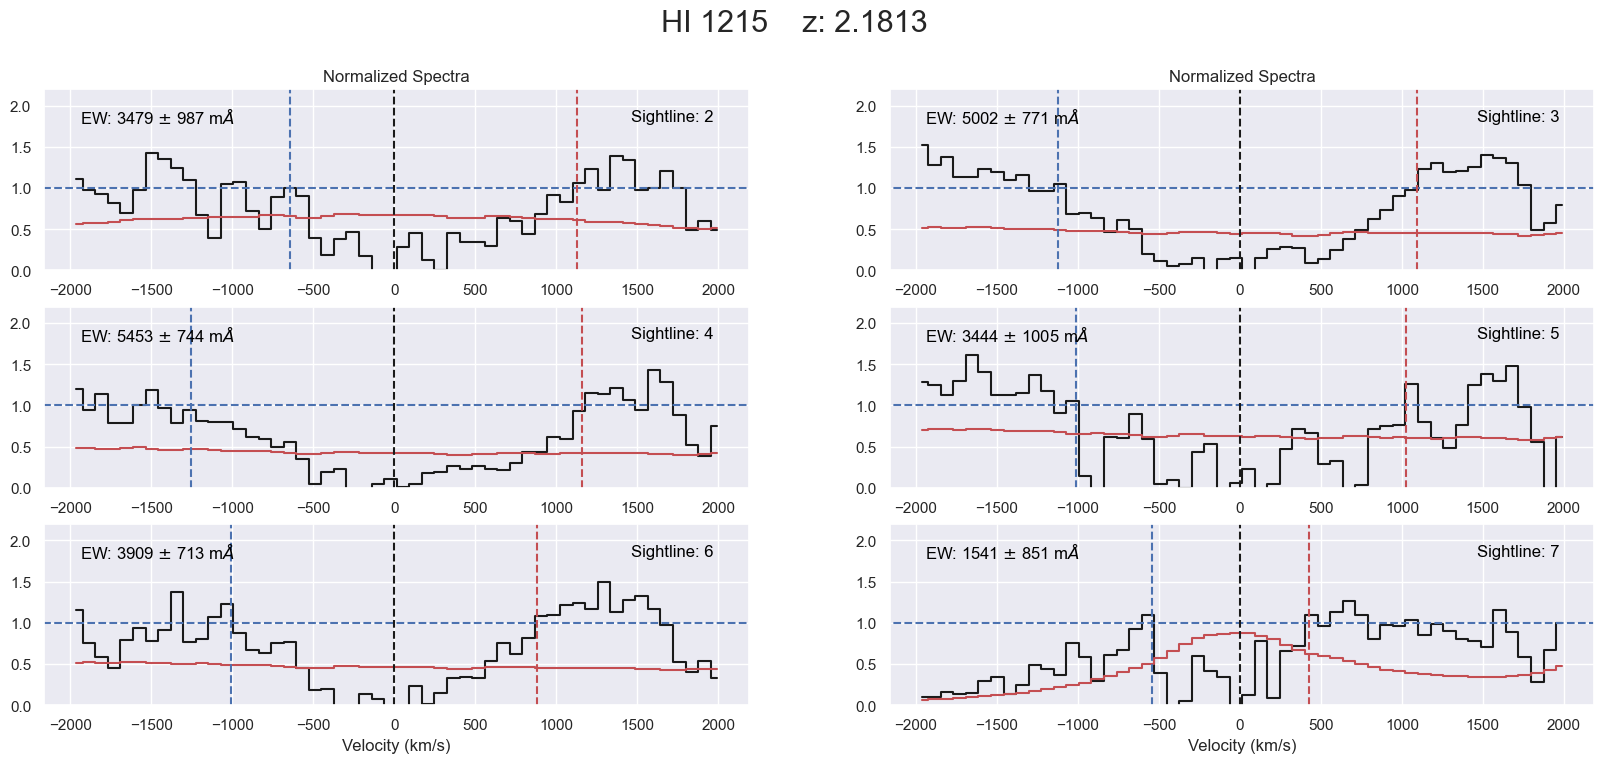

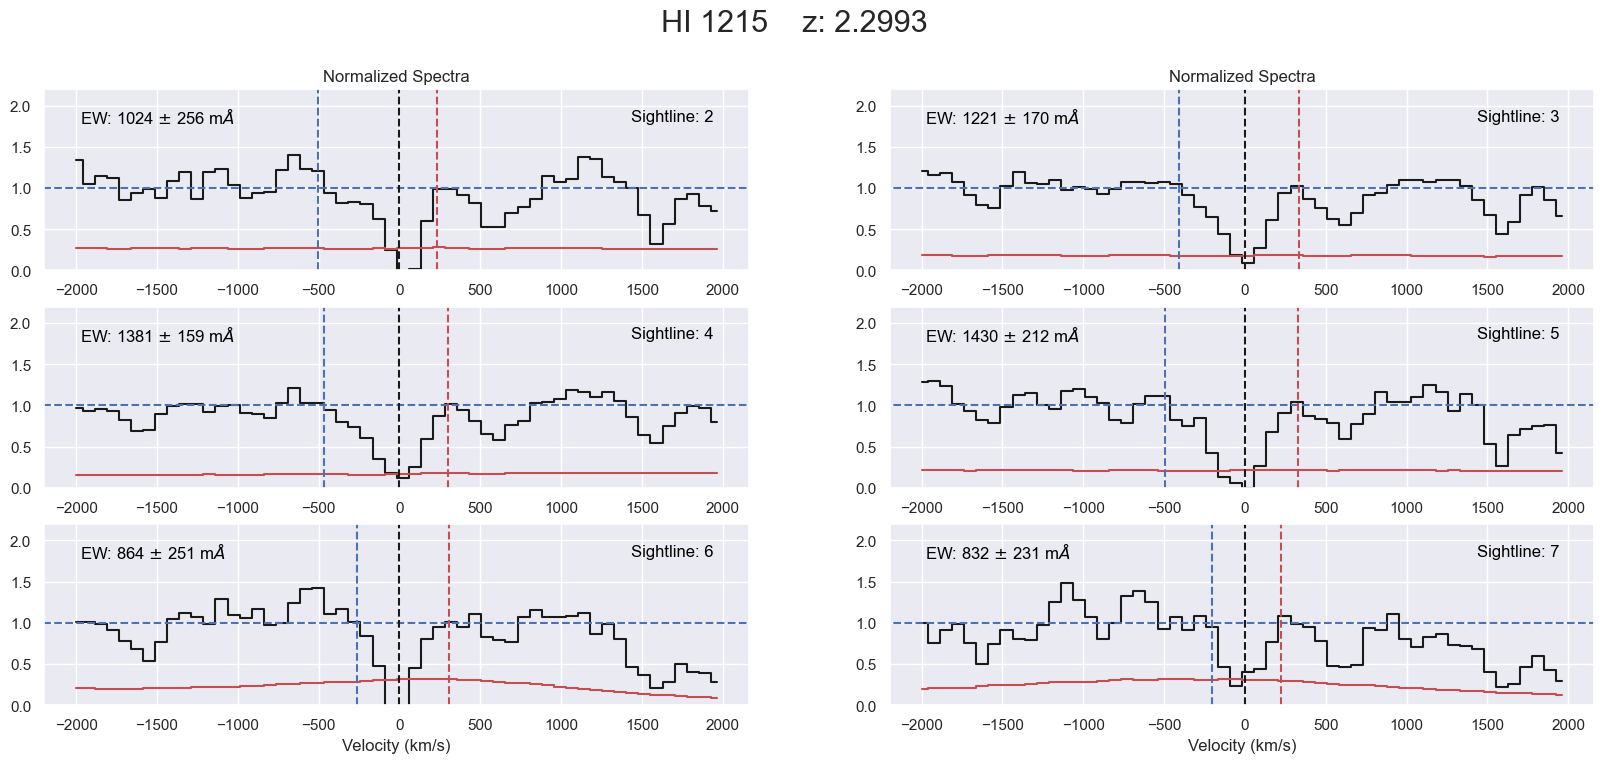

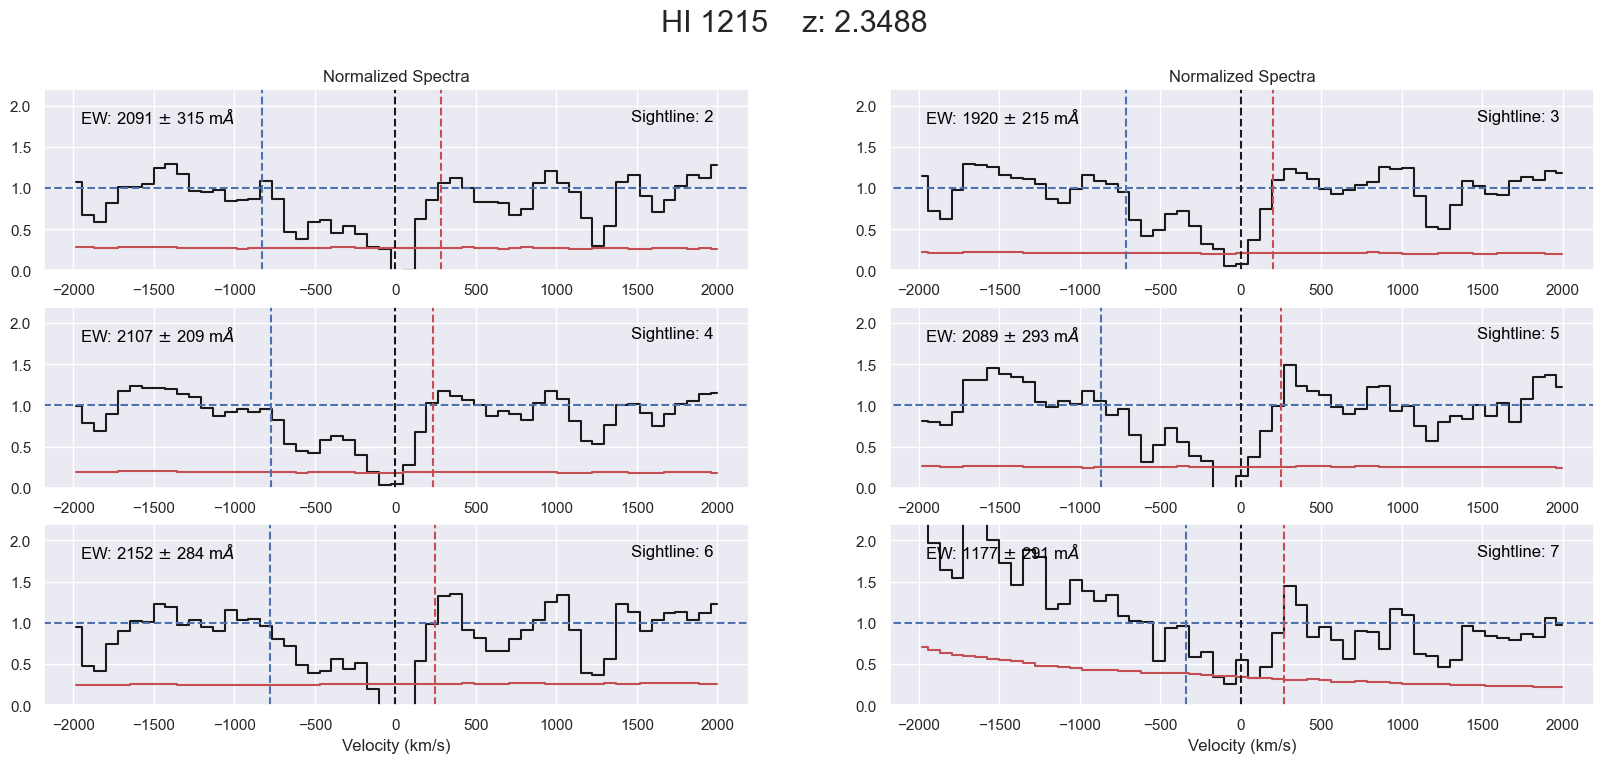

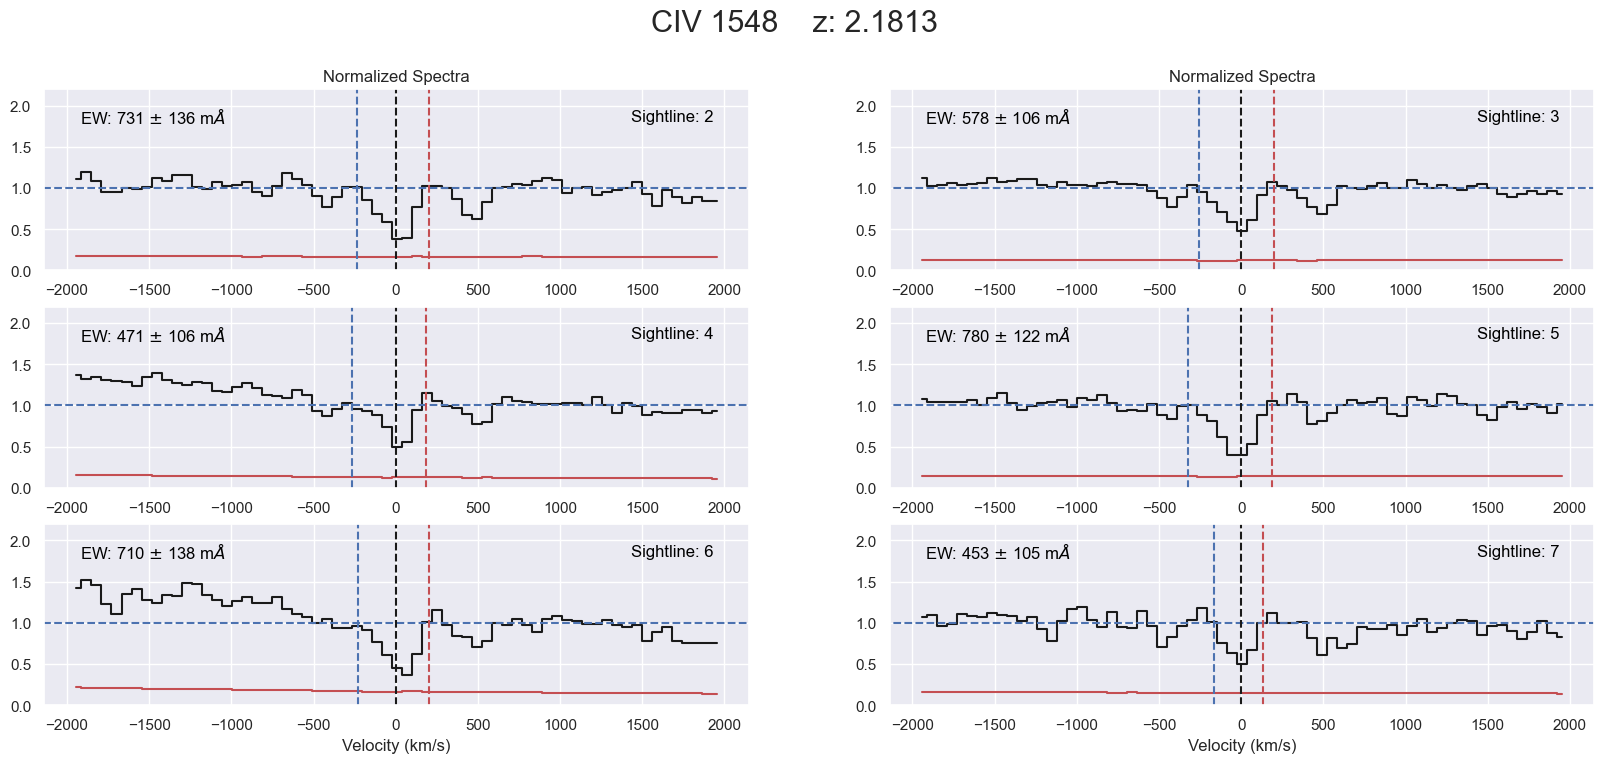

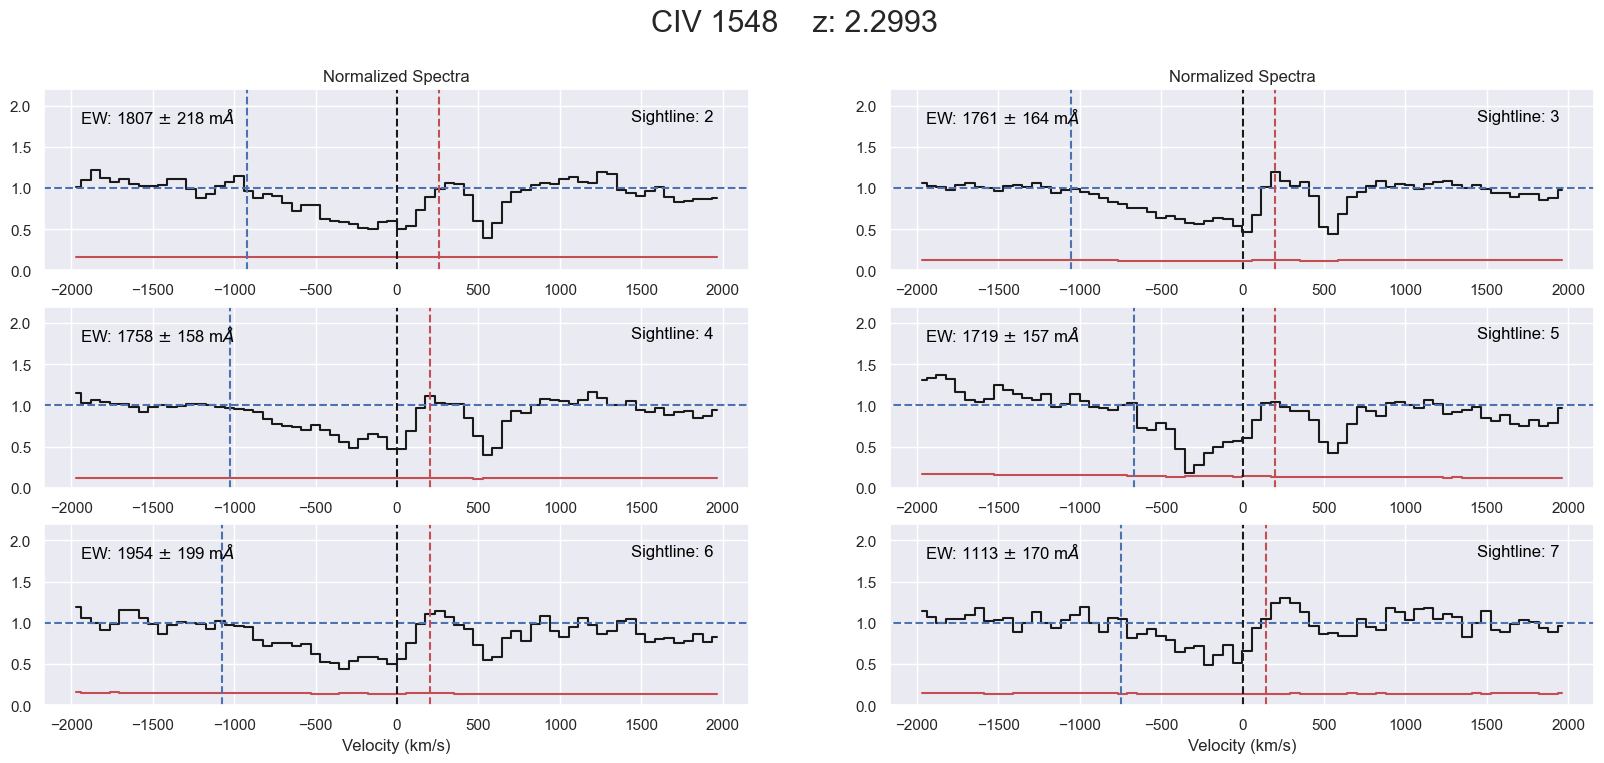

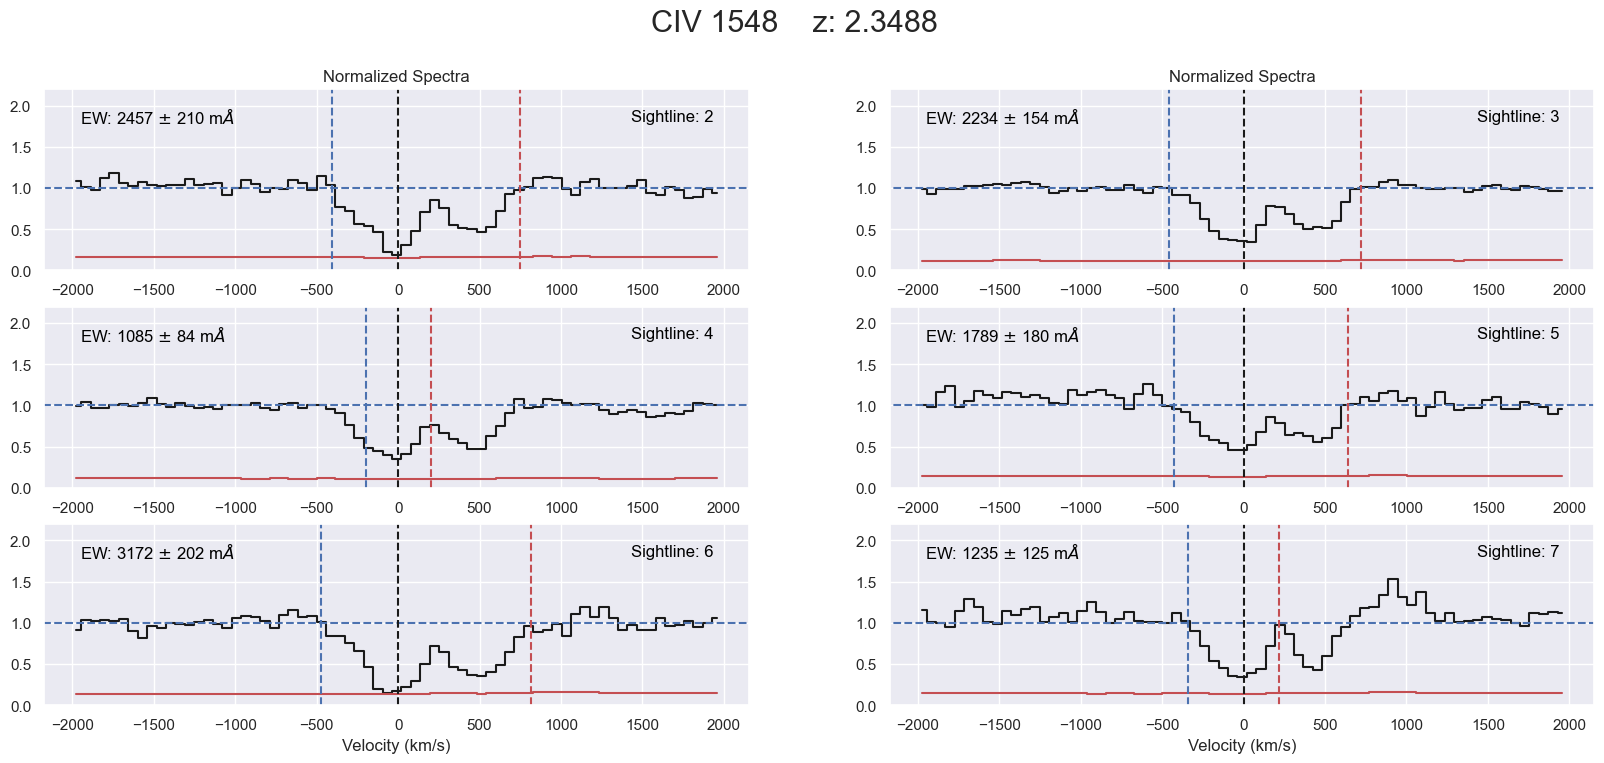

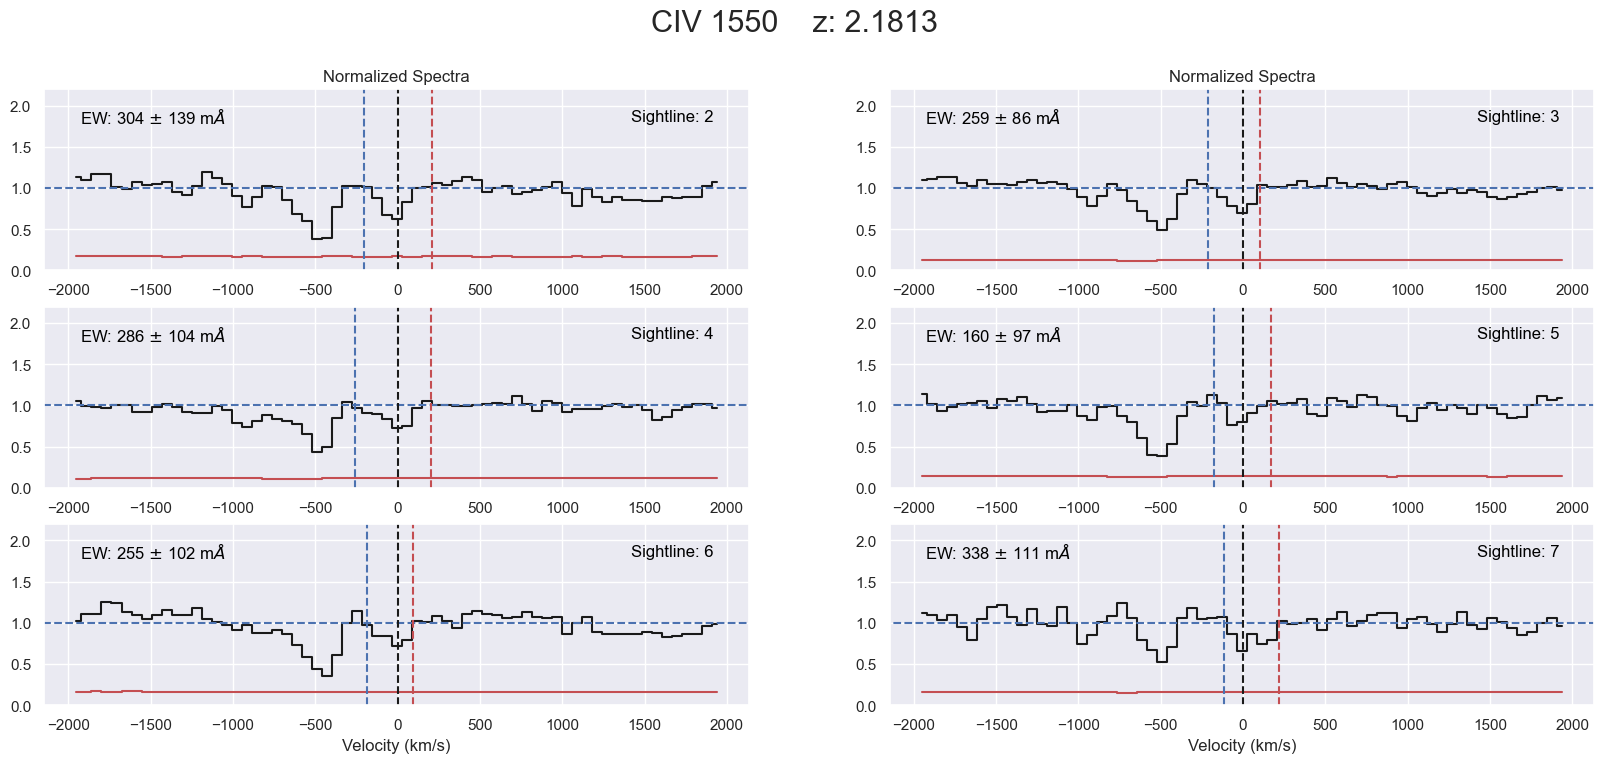

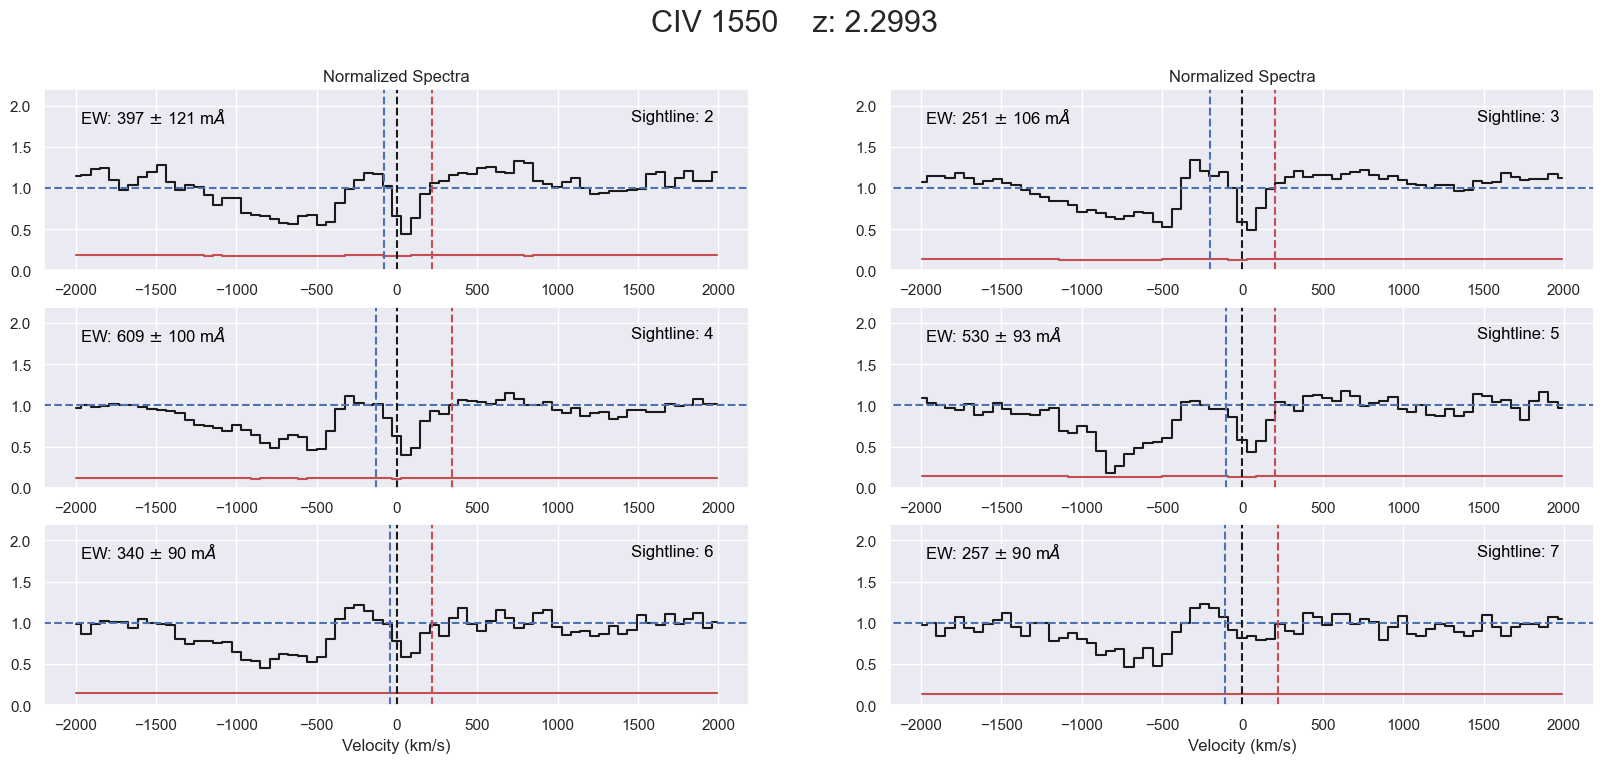

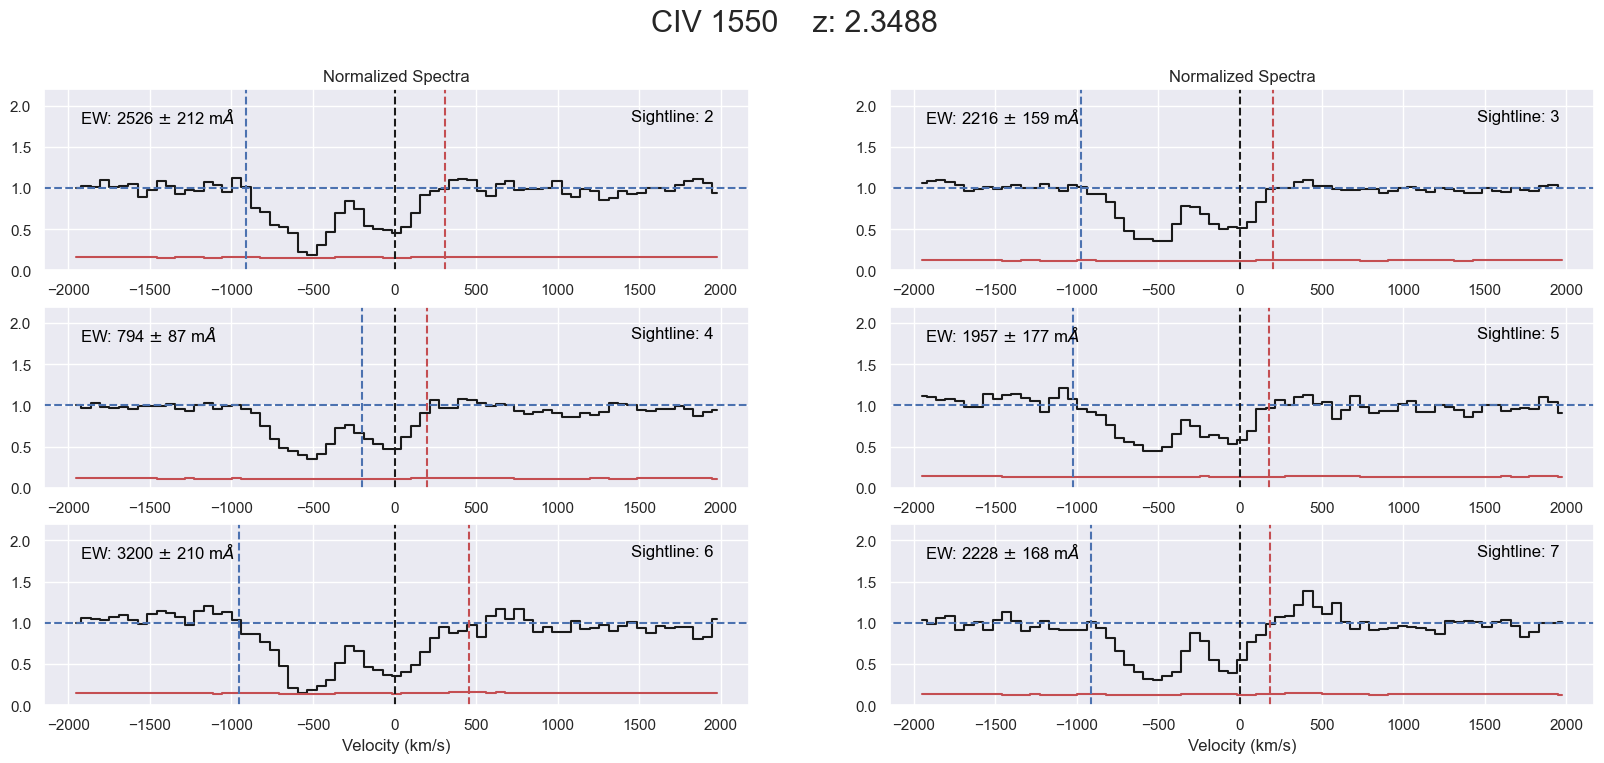

In [13]:
zsf = {}
for i,pfile in enumerate(files):
    # if i > 1: break
    (sl, z) = get_tuple_from_path(pfile)
    label = f"SL: {sl}    z: {z}"
    if z not in zsf: zsf[z] = {}
    zsf[z][sl] = pfile
    
def count_sightlines(z, zsf):
    """ how many sightlines do we have for a specific redshift """
    return len(zsf[z])

def display_selected_ion(ion_str):
    for z in list(zsf):
        # if z != 2.1813: break
        sl_cnt = count_sightlines(z, zsf)
        fig, ax_list = init_figure(f"z: {z}", sl_cnt)
    
        for ii, sl in enumerate(zsf[z]):
            # print(f"sl: {sl}")
            pfile = zsf[z][sl]
        
            with open(pfile,'rb') as pickle_file:
                ions = pickle.load(pickle_file)
                pickle_file.close()
                # print(f"ion count: {len(ions.keys())}")
                for ion in ions:
                    # if ion is not None and (ion == 'CIV 1548' or ion == 'CIV 1550' or ion == 'HI 1215'):
                    if ion is not None and (ion == ion_str):
                        fig.suptitle(f"{ion}    z: {z}", size=22.0, weight=0.5)
    
                        if ii < 2: is_top=True
                        else: is_top = False
                        if ii >= 4: is_bottom = True
                        else: is_bottom = False
                        plot_ion_panel_condensed(ax_list[ii], ions[ion], label=f"Sightline: {sl}", is_top=is_top, is_bottom=is_bottom)
    
display_selected_ion("HI 1215")
display_selected_ion("CIV 1548")
display_selected_ion("CIV 1550")

